In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import matplotlib.pyplot as plt
from scipy import random
from scipy.stats import multivariate_normal


In [3]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

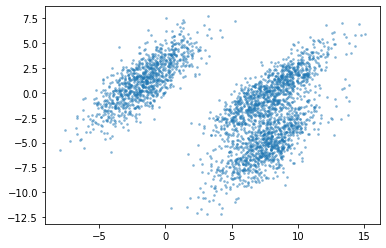

In [4]:
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [5]:
x=tf.convert_to_tensor(X,dtype=tf.float64)

In [6]:
k=3
d=x.shape[1]
n=x.shape[0]

In [7]:
pi=np.array([0.3333,0.3333,0.3333])
mu=np.array([x[6],x[100],x[46]])
sigma=np.array([[[1.0,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
z=np.zeros(shape=(n,k))


pi=tf.Variable(pi,dtype=tf.float64)
mu=tf.Variable(mu,dtype=tf.float64)
sigma=tf.Variable(sigma,dtype=tf.float64)
z=tf.Variable(z,dtype=tf.float64)

In [104]:
# E-step.
for i in range(k):
    N = tfp.distributions.MultivariateNormalFullCovariance(loc=mu[i],covariance_matrix=sigma[i]).prob(x)
    z[:, i].assign(pi[i] * N)
    z.assign(z/tf.reduce_sum(z,axis=1, keepdims=True))

In [13]:
z

<tf.Variable 'Variable:0' shape=(3000, 3) dtype=float64, numpy=
array([[9.67767200e-01, 2.97102124e-02, 2.52258721e-03],
       [9.97593242e-01, 2.31818368e-03, 8.85740467e-05],
       [1.12095163e-02, 1.74610071e-01, 8.14180412e-01],
       ...,
       [1.00000000e+00, 1.19956879e-23, 1.74787232e-26],
       [1.00000000e+00, 2.77642116e-32, 5.71437532e-36],
       [1.00000000e+00, 1.80628595e-32, 1.30858002e-36]])>

In [105]:
# M-step
N_k=tf.reduce_sum(z,axis=0)
pi=N_k/n
mu = tf.matmul(tf.transpose(z),x)
mu/N_k[:,None]

for i in range(k):
    tmp=x-mu[i]
    tmp=tf.reshape(tmp,[n,d,1])
    tmp_T=tf.transpose(tmp,perm=[0,2,1])
    res=tf.matmul(tmp,tmp_T)
    res=tf.multiply(tf.reshape(z[:,i],[n,1,1]),res)
    res=tf.reduce_sum(res,axis=0)/N_k[i]
    sigma[i].assign(res)



In [106]:
sigma

<tf.Variable 'Variable:0' shape=(3, 2, 2) dtype=float64, numpy=
array([[[ 1.12502861e+08, -4.78389772e+07],
        [-4.78389772e+07,  2.03423171e+07]],

       [[ 3.95557589e+06,  7.86497193e+05],
        [ 7.86497193e+05,  1.56381674e+05]],

       [[ 1.72944143e+06,  5.94532253e+05],
        [ 5.94532253e+05,  2.04384029e+05]]])>

In [18]:
N_k/n

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.89824986, 0.0415231 , 0.06022704])>

In [20]:
pi

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.89824986, 0.0415231 , 0.06022704])>

In [23]:
mu.shape

TensorShape([3, 2])

In [29]:
N_k[:,None]

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[2694.74956665],
       [ 124.56931412],
       [ 180.68111923]])>

In [30]:
N_k

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2694.74956665,  124.56931412,  180.68111923])>

In [24]:
tf.transpose(z).shape

TensorShape([3, 3000])

In [25]:
x.shape

TensorShape([3000, 2])

In [32]:
mu/N_k[:,None]

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[ 4.0178531 , -1.66371498],
       [ 9.43263791,  1.84758561],
       [10.69788578,  3.28956761]])>

In [33]:
mu

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[10827.10789168, -4483.29522979],
       [ 1175.01723505,   230.15247261],
       [ 1932.90597602,   594.36275686]])>

In [34]:
N_k

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2694.74956665,  124.56931412,  180.68111923])>

In [35]:
sigma

<tf.Variable 'Variable:0' shape=(3, 2, 2) dtype=float64, numpy=
array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]])>

In [36]:
x

<tf.Tensor: shape=(3000, 2), dtype=float64, numpy=
array([[ 7.16820992,  0.55372227],
       [ 6.44440392, -0.28221635],
       [ 9.61672627,  3.42218544],
       ...,
       [-1.94290317,  0.22435701],
       [-3.52456668, -1.11954922],
       [-3.13203298, -2.46183127]])>

In [38]:
mu[0]

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([10827.10789168, -4483.29522979])>

In [49]:
tmp=x-mu[0]

In [52]:
tf.transpose(tmp[0])

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-10819.93968176,   4483.84895206])>

In [58]:
tf.matmul(tmp[0],tf.transpose(tmp[0]))

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 1.17071095e+08, -4.85149752e+07],
       [-4.85149752e+07,  2.01049014e+07]])>

In [57]:
tmp=tf.reshape(tmp,[3000,2,1])

In [59]:
tmp.shape

TensorShape([3000, 2, 1])

In [64]:
tmp_T=tf.transpose(tmp,perm=[0,2,1])

In [66]:
tf.matmul(tmp,tmp_T)[0]

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 1.17071095e+08, -4.85149752e+07],
       [-4.85149752e+07,  2.01049014e+07]])>

In [67]:
tf.matmul(tmp[0],tmp_T[0])

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 1.17071095e+08, -4.85149752e+07],
       [-4.85149752e+07,  2.01049014e+07]])>

In [72]:
res=tf.matmul(tmp,tmp_T)

In [73]:
res.shape

TensorShape([3000, 2, 2])

In [79]:
z[:,0]

<tf.Tensor: shape=(3000,), dtype=float64, numpy=
array([0.9677672 , 0.99759324, 0.01120952, ..., 1.        , 1.        ,
       1.        ])>

In [94]:
res=tf.multiply(tf.reshape(z[:,0],[3000,1,1]),res)

In [100]:
tf.reduce_sum(res,axis=0)/N_k[0]

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[ 1.17139300e+08, -4.85051085e+07],
       [-4.85051085e+07,  2.00850333e+07]])>

In [101]:
sigma[0]=tf.reduce_sum(res,axis=0)/N_k[0]

TypeError: ignored